# Autism spectrum disorder (ASD) classification from resting state fmri data
Autism Brain Imaging Data Exchange (ABIDE) was launched in 2012.  ABIDE II is a multisite open-data resource which is an aggregate of resting state functional magnetic resonance imaging (MRI) and corresponding structural MRI and phenotypic datasets. ABIDE II includes datasets from  487 individuals with ASD and 557 controls previously collected across 16 international institutions. 

The initial ABIDE initiative—now termed ABIDE I—was the first open-access brain imaging repository of resting state functional magnetic resonance imaging (R-fMRI) and corresponding structural data of individuals with ASD and typical controls aggregated from multiple international institutions.

ABIDE II has 1004 samples and each sample has 1446 features. ABIDE II dataset is available in the **ndslib** module which is imported.

In [3]:
from ndslib.data import load_data
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

In [6]:
abide_data = load_data("abide2")
print('shape of the dataset: ', abide_data.shape)
abide_data.head()

shape of the dataset:  (1004, 1446)


,site,subject,age,sex,group,age_resid,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,fsArea_L_V2_ROI,...,fsCT_R_p47r_ROI,fsCT_R_TGv_ROI,fsCT_R_MBelt_ROI,fsCT_R_LBelt_ROI,fsCT_R_A4_ROI,fsCT_R_STSva_ROI,fsCT_R_TE1m_ROI,fsCT_R_PI_ROI,fsCT_R_a32pr_ROI,fsCT_R_p24_ROI
0,ABIDEII-KKI_1,29293,8.893151,2.0,1.0,13.642852,2750.0,306.0,354.0,2123.0,...,3.362,2.827,2.777,2.526,3.202,3.024,3.354,2.629,2.699,3.179
1,ABIDEII-OHSU_1,28997,12.000000,2.0,1.0,16.081732,2836.0,186.0,354.0,2261.0,...,2.809,3.539,2.944,2.769,3.530,3.079,3.282,2.670,2.746,3.324
2,ABIDEII-GU_1,28845,8.390000,1.0,2.0,12.866264,3394.0,223.0,373.0,2827.0,...,2.435,3.321,2.799,2.388,3.148,3.125,3.116,2.891,2.940,3.232
3,ABIDEII-NYU_1,29210,8.300000,1.0,1.0,13.698139,3382.0,266.0,422.0,2686.0,...,3.349,3.344,2.694,3.030,3.258,2.774,3.383,2.696,3.014,3.264
4,ABIDEII-EMC_1,29894,7.772758,2.0,2.0,14.772459,3080.0,161.0,346.0,2105.0,...,2.428,2.940,2.809,2.607,3.430,2.752,2.645,3.111,3.219,4.128


In [8]:
features = abide_data.filter(like='fs') # all feature columns starts with 'fs'
# features.head()
phenotypes = abide_data.iloc[:, :6]  # first 6  columns of all
# samples are put in a dataframe called phenotypes

In [9]:
# Check for missing values in each column
missing_percentage = (features.isnull().sum() / len(features)) * 100

# Filter columns with missing values
missing_cols = missing_percentage[missing_percentage > 0]

if not missing_cols.empty:
    print("Columns with missing values:")
    print(missing_cols)
else:
    print("No columns have missing values.")

No columns have missing values.


In [10]:
X = features # X is now the feature vector
y = pd.to_numeric(phenotypes['group'])
y = y - 1 #make encoding to  0 and 1 from the default 1 and 2


## PCA

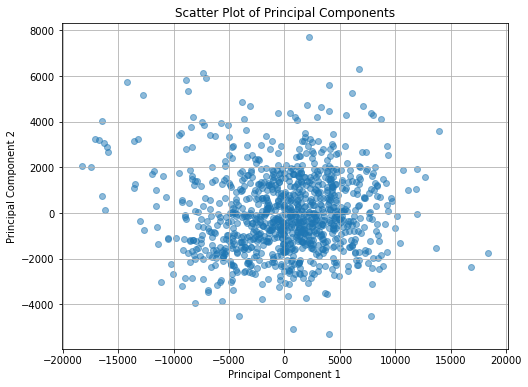

In [12]:
# Assuming 'X' is your feature matrix
# Initialize PCA
pca = PCA(n_components=10)  # Specify the number of principal components you want to compute

# Fit PCA and transform the data
X_pca = pca.fit_transform(X)

# 'X_pca' now contains the transformed data with the principal components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of Principal Components')
plt.grid(True)
plt.savefig("PCA.png")
plt.show()

# Classification
## Gaussian Naive Bayes  (GNB)
Naive bayes is a simple classification approach based ona naive application of Baye's Theorem. The naivete stems from the classifier's assumption that all features are independent of one another once we condition on class assignment. GNB is a good classifier to use as a performance baseline.  
Here all 1440 features are thrown at the classifier, and try to predict the diagnosis class. 
The feature matrix X and the label vector y is split in 0.8:0.2 train:test ratio.

Accuracy: 0.582089552238806
              precision    recall  f1-score   support

         0.0       0.55      0.40      0.46        91
         1.0       0.60      0.74      0.66       110

    accuracy                           0.58       201
   macro avg       0.57      0.57      0.56       201
weighted avg       0.58      0.58      0.57       201



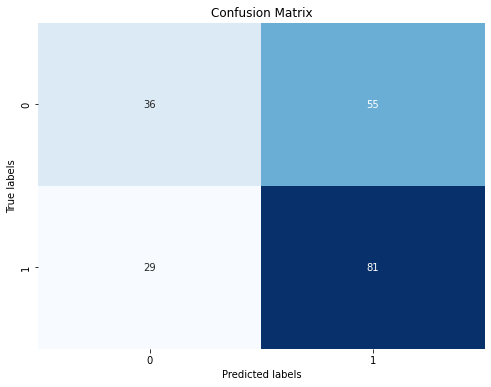

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

gnb = GaussianNB()
gnb = gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred))



# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig("GNB_all.png")
plt.show()

 while precision is almost identical for the two groups, the recall or sensitivity differs substantially: control subjects have higher probability  (73%)  of being correctly labeled than subjects with an autism diagnosis (34%). This suggests a bias in the model, namely that the model is more likely to assign cases to the control group  than the autism group. 

## Random forest classifier


Accuracy: 0.6069651741293532
Classification Report:
              precision    recall  f1-score   support

         0.0       0.58      0.47      0.52        91
         1.0       0.62      0.72      0.67       110

    accuracy                           0.61       201
   macro avg       0.60      0.60      0.59       201
weighted avg       0.60      0.61      0.60       201



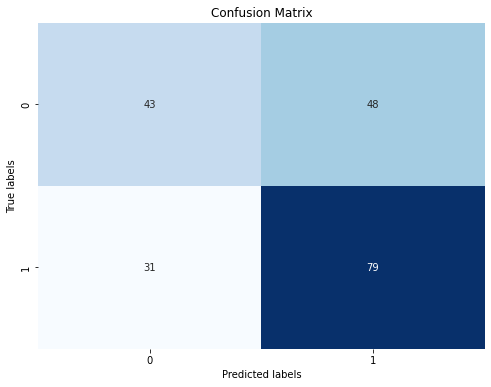

In [14]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig("randomforest_all.png")
plt.show()

## XGBoost

Accuracy: 0.6368159203980099
Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.59      0.60        91
         1.0       0.67      0.67      0.67       110

    accuracy                           0.64       201
   macro avg       0.63      0.63      0.63       201
weighted avg       0.64      0.64      0.64       201



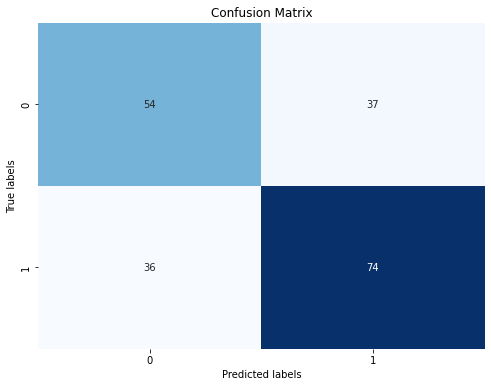

In [15]:
# Create an XGBoost classifier
model = xgb.XGBClassifier()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig("XGB_all.png")
plt.show()

## Lasso

Accuracy: 0.5422885572139303
Classification Report:
              precision    recall  f1-score   support

         0.0       0.49      0.48      0.49        91
         1.0       0.58      0.59      0.59       110

    accuracy                           0.54       201
   macro avg       0.54      0.54      0.54       201
weighted avg       0.54      0.54      0.54       201



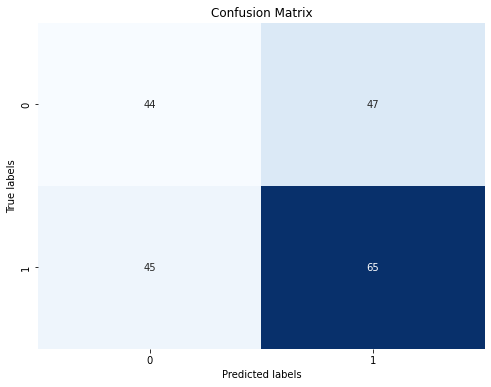

In [16]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Logistic Regression classifier with Lasso regularization
lasso_logreg = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)

# Train the classifier on the training data
lasso_logreg.fit(X_train_scaled, y_train)

# Make predictions on the testing data
y_pred = lasso_logreg.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig("lasso_all.png")
plt.show()



All the above classification models have less accuracy. To improve the performance, we can find the important features from 1400 features rather than using everything. 
  One such method is called **recursive feature elimination (RFE)** it is a feature selection technique that recursively removes features from a model based on their importance, typically using model coefficients or feature importances. It's an iterative approach that starts with all features and gradually eliminates less important ones until the desired number of features is reached. 
  
 Here I am trying to find 100 most important features. 




## RFE

In [18]:
# Assuming 'X' is your feature matrix and 'y' is your target variable
# Initialize the model with a higher max_iter value
model = LogisticRegression(max_iter=4000)  # Increase max_iter to 1000

# Initialize RFE
rfe = RFE(model, n_features_to_select= 100)  # Specify the number of features to select

# Fit RFE on scaled training data
rfe.fit(X_train_scaled, y_train)

# Get selected features
selected_features = X.columns[rfe.support_]

# Now 'selected_features' contains the names of the selected features

instead of using the  entire feature space, we use the **selected_features** obtained using the  **RFE** method  in the above implemented classification models and check if the model improves.

## GNB, but using "important" features

Accuracy: 0.582089552238806
Classification Report:
              precision    recall  f1-score   support

         0.0       0.55      0.40      0.46        91
         1.0       0.60      0.74      0.66       110

    accuracy                           0.58       201
   macro avg       0.57      0.57      0.56       201
weighted avg       0.58      0.58      0.57       201



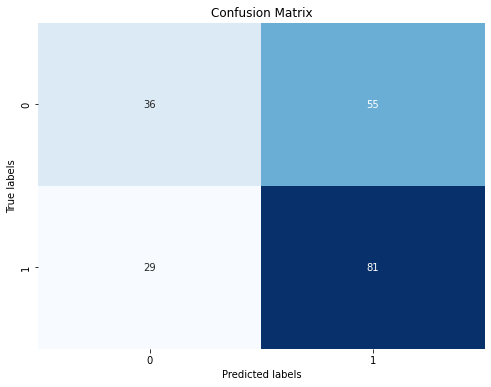

In [19]:
X = features # X is now the feature vector
y = pd.to_numeric(phenotypes['group'])
y = y - 1 #make encoding to  0 and 1 from the default 1 and 2

imp_features = features[selected_features].copy()
X = imp_features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

gnb = GaussianNB()
gnb = gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig("GNB_imp.png")
plt.show()

## Random forest, but using "important" features

Accuracy: 0.582089552238806
Classification Report:
              precision    recall  f1-score   support

         0.0       0.55      0.46      0.50        91
         1.0       0.60      0.68      0.64       110

    accuracy                           0.58       201
   macro avg       0.58      0.57      0.57       201
weighted avg       0.58      0.58      0.58       201



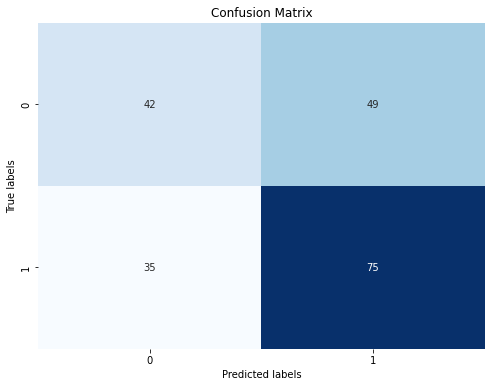

In [20]:
X = features # X is now the feature vector
y = pd.to_numeric(phenotypes['group'])
y = y - 1 #make encoding to  0 and 1 from the default 1 and 2

imp_features = features[selected_features].copy()
X = imp_features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig("randomforest_imp.png")
plt.show()

## XGBoost, but using "important" features

Accuracy: 0.6019900497512438
Classification Report:
              precision    recall  f1-score   support

         0.0       0.55      0.63      0.59        91
         1.0       0.65      0.58      0.62       110

    accuracy                           0.60       201
   macro avg       0.60      0.60      0.60       201
weighted avg       0.61      0.60      0.60       201



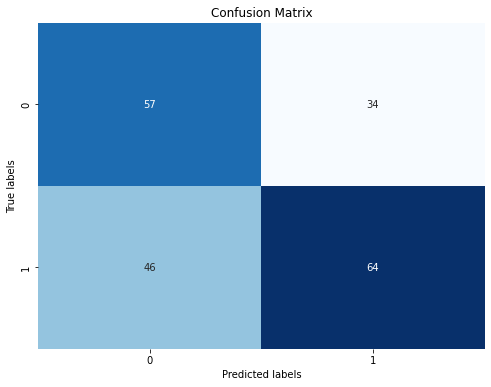

In [21]:
X = features # X is now the feature vector
y = pd.to_numeric(phenotypes['group'])
y = y - 1 #make encoding to  0 and 1 from the default 1 and 2

imp_features = features[selected_features].copy()
X = imp_features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create an XGBoost classifier
model = xgb.XGBClassifier()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig("XGB_imp.png")
plt.show()

## Lasso, but using "important" features

Accuracy: 0.5522388059701493
Classification Report:
              precision    recall  f1-score   support

         0.0       0.51      0.47      0.49        91
         1.0       0.59      0.62      0.60       110

    accuracy                           0.55       201
   macro avg       0.55      0.55      0.55       201
weighted avg       0.55      0.55      0.55       201



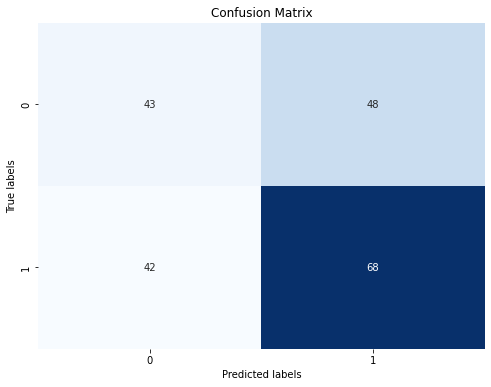

In [22]:
X = features # X is now the feature vector
y = pd.to_numeric(phenotypes['group'])
y = y - 1 #make encoding to  0 and 1 from the default 1 and 2

imp_features = features[selected_features].copy()
X = imp_features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Logistic Regression classifier with Lasso regularization
lasso_logreg = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)

# Train the classifier on the training data
lasso_logreg.fit(X_train_scaled, y_train)

# Make predictions on the testing data
y_pred = lasso_logreg.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig("lasso_imp.png")
plt.show()


## A simple feedforward Neural network model

In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical


# Load your dataset
# Assuming 'data' is your DataFrame where the last column contains the target labels

X = features # X is now the feature vector
y = pd.to_numeric(phenotypes['group'])
y = y - 1 #make encoding to  0 and 1 from the default 1 and 2
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert target labels to categorical
num_classes = len(np.unique(y))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Output layer with softmax activation for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)



/home/ashish/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-01 16:27:10.156843: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-01 16:27:10.374837: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the requi

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4977 - loss: 797.3257 - val_accuracy: 0.4179 - val_loss: 4.9020
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5445 - loss: 1.4876 - val_accuracy: 0.5473 - val_loss: 0.6913
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5485 - loss: 0.6927 - val_accuracy: 0.5473 - val_loss: 0.6905
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5114 - loss: 0.6933 - val_accuracy: 0.5473 - val_loss: 0.6905
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5347 - loss: 0.6913 - val_accuracy: 0.5473 - val_loss: 0.6900
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5397 - loss: 0.6906 - val_accuracy: 0.5473 - val_loss: 0.6896
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5602 - loss: 0.6886 - val_accuracy: 0.5473 - val_loss: 0.6895
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5355 - loss: 0.6910 - val_accuracy: 0.5473 - val_lo

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


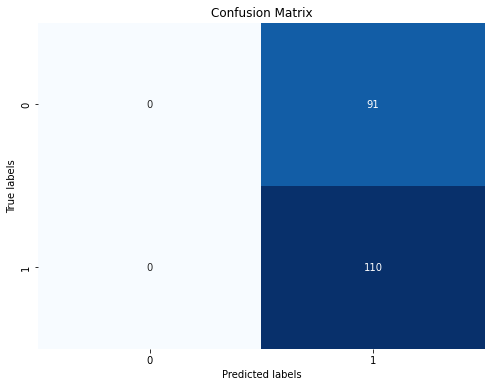

In [32]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# True classes
y_true = np.argmax(y_test, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig("lasso_imp.png")
plt.savefig("NN1.png")

plt.show()

In [34]:
X = imp_features
y = pd.to_numeric(phenotypes['group'])
y = y - 1 #make encoding to  0 and 1 from the default 1 and 2
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert target labels to categorical
num_classes = len(np.unique(y))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Output layer with softmax activation for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)


Epoch 1/10


/home/ashish/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4921 - loss: 675.9473 - val_accuracy: 0.5025 - val_loss: 43.2709
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4747 - loss: 246.1705 - val_accuracy: 0.5522 - val_loss: 12.1010
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4951 - loss: 99.6855 - val_accuracy: 0.5970 - val_loss: 8.4160
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5330 - loss: 53.4775 - val_accuracy: 0.4975 - val_loss: 8.3786
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5333 - loss: 27.3552 - val_accuracy: 0.4776 - val_loss: 5.2095
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5076 - loss: 15.2472 - val_accuracy: 0.5025 - val_loss: 2.1964
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5487 - loss: 4.5937 - val_accuracy: 0.5572 - val_loss: 1.5053
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5380 - loss: 2.5333 - val_accuracy: 0.5970 - val_loss: 